In [1]:
from batchedCartpole import CartPole
import sys
sys.path.append("../ES")
from ES_NeuralGraph import NeuralGraph
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [2]:
n_inp = 4
n_out = 3
n_hid = 0
n_reward = 1 # Counts as one extra inp node as far as the graphs concerned

n_nodes = n_inp + n_out + n_hid + n_reward

device = "cuda" if torch.cuda.is_available() else "cpu"

# connections = torch.Tensor([[i, j] for i in range(n_nodes) for j in range(n_nodes)]).long().to(device)

# Only have one way connections from inps to actions
connections = torch.Tensor([[i, j] for i in range(n_inp) for j in range(n_nodes - n_out, n_nodes)])# .long().to(device)

# OMG I WAS SOOOO CONFUSED WHY THIS WASN'T WORKING AT ALL AND I JUST REALIZED THAT THE REWARD NODE ISN'T HOOKED TO ANYTHING.
# AKSLJDHLKJASDFGHLKAJSFHALSKDJHALSKDFJHASLKDFJCHASLKJFCHASLKJDHASKLIJDH
# Just connect it to everything...
connections = torch.cat([connections, torch.Tensor([[n_inp, j] for j in range(n_nodes)] + [[j, n_inp] for j in range(n_nodes)])]).long().to(device)


# TODO: Also want to give it access to random node so it can do random actions if desired to "explore"


print(len(connections))

graph = NeuralGraph(n_nodes, n_inp + n_reward, n_out, connections, ch_n=8, ch_e=8, clamp_mode="hard", max_value=5, init_mode="trainable", set_nodes=True, aggregation="mean", 
                     use_label=False, n_models=1).to(device)

env = CartPole(device=device)

optimizer = torch.optim.Adam(graph.parameters(), lr=1e-4)

log = []

28


KeyboardInterrupt: 

In [ ]:
EPOCHS = 10_000
STEPS = 256

BATCH_SIZE = 512
TIME = 2
DT = 1

bar = tqdm(range(EPOCHS))

for _ in bar:
    with torch.no_grad():
        graph.generate_epsilons(BATCH_SIZE)
        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
        state = env.initialize(BATCH_SIZE)
        reward = torch.zeros(BATCH_SIZE).to(device)
        optimizer.zero_grad()

        regret = torch.zeros(BATCH_SIZE).to(device)

        for _ in range(STEPS):
            # Also for some FUCKING reason I have edges=False?!?!?!?!?!?
            # Why did I decide that was a good idea??????
            action_dist = graph.forward(torch.cat([state, reward.unsqueeze(-1)], axis=-1), TIME, DT, apply_once=False, nodes=True, edges=True).softmax(-1)
            action = action_dist.argmax(-1)# torch.multinomial(action_dist, 1).squeeze(-1)
            reward = env.step(action)
            regret -= reward / STEPS

        graph.estimate_grads(regret)

        optimizer.step()

        log.append(regret.mean().item())

        bar.set_postfix({f"Avg. normed Regret":regret.mean().item()})

100%|██████████| 10000/10000 [4:28:38<00:00,  1.61s/it, Avg. normed Regret=1.2]  


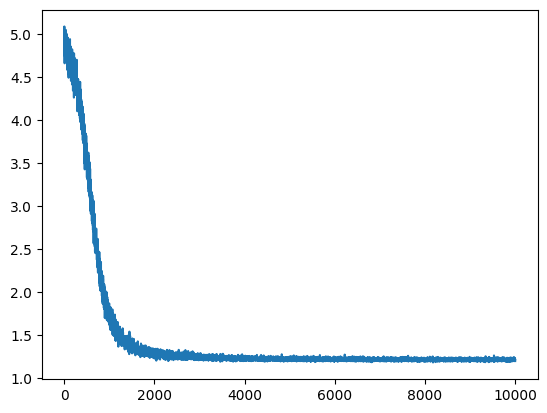

In [12]:
plt.plot(log)

In [12]:
torch.save(graph, "RL.pt")

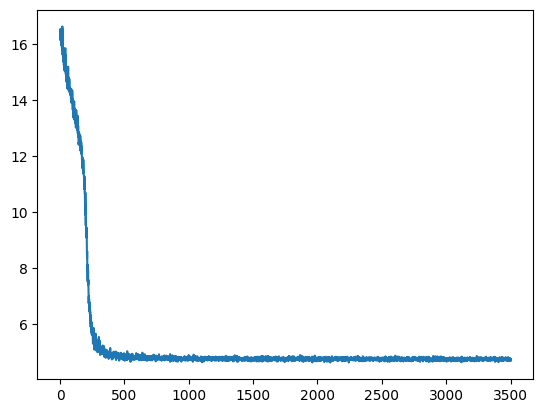

In [11]:
plt.plot(log)